In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Big Query

In [2]:
from google.cloud import bigquery

In [3]:
client=bigquery.Client()

Using Kaggle's public dataset BigQuery integration.


In [ ]:
# Construct a reference to the "hacker_news" dataset
dataset_ref = client.dataset("hacker_news", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

In [ ]:
tables = list(client.list_tables(dataset))

In [ ]:
for table in tables:
    print(table.table_id)

In [ ]:
table_ref = dataset_ref.table("full")
table = client.get_table(table_ref)

In [ ]:
table.description

In [ ]:
table.num_rows

## Table Schema

In [ ]:
table.schema

In [ ]:
client.list_rows(table,max_results=5)

In [ ]:
client.list_rows(table,max_results=5).to_dataframe()

In [ ]:
client.list_rows(table, selected_fields=table.schema[:1], max_results = 5).to_dataframe()

## Select, From and Where in Bigquery

In [ ]:
dataset_ref=(client.dataset("openaq", project = "bigquery-public-data"))
dataset=client.get_dataset(dataset_ref)

tables = list(client.list_tables(dataset))
for table in tables:
    print(table.table_id)

In [ ]:
table_ref = dataset_ref.table("global_air_quality")
table = client.get_table(table_ref)

client.list_rows(table, max_results=5).to_dataframe()

In [ ]:
query="""SELECT city
         FROM `bigquery-public-data.openaq.global_air_quality`
         WHERE country = 'US'"""

In [ ]:
client=bigquery.Client()
query_job = client.query(query)

us_cities = query_job.to_dataframe()

us_cities

In [ ]:
us_cities.city.value_counts().head()

Since there is a limit of 5TB, you can first calculate the size of the query:

In [ ]:
query="""SELECT city,country
         FROM `bigquery-public-data.openaq.global_air_quality`
         WHERE country = 'US'"""

dry_run_config = bigquery.QueryJobConfig(dry_run = True)

dry_run_query_job=client.query(query,job_config = dry_run_config)

print(f'This query will process {dry_run_query_job.total_bytes_processed} bytes')

In [ ]:
print(f'This query will process {(dry_run_query_job.total_bytes_processed)/1000000} mb')

In [ ]:
print(f'This query will process {(dry_run_query_job.total_bytes_processed)/1000000000} gb')

You can also specify a parameter when running the query to limit how much data you are willing to scan. Here's an example with a low limit.

In [ ]:
# Only run the query if it's less than 1 MB
ONE_MB = 1000*1000
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=ONE_MB)

# Set up the query (will only run if it's less than 1 MB)
safe_query_job = client.query(query, job_config=safe_config)

# API request - try to run the query, and return a pandas DataFrame
safe_query_job.to_dataframe()

In [ ]:
# Only run the query if it's less than 1 MB
ONE_MB = 1000*1000
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=100000000)

# Set up the query (will only run if it's less than 1 MB)
safe_query_job = client.query(query, job_config=safe_config)

# API request - try to run the query, and return a pandas DataFrame
safe_query_job.to_dataframe()

The query gets cancelled if the limit of 1 MB exceeds. However, we can increase the limit to run the query successfully!

In [ ]:
# Only run the query if it's less than 1 GB
ONE_GB = 1000*1000*1000
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=ONE_GB)

# Set up the query (will only run if it's less than 1 GB)
safe_query_job = client.query(query, job_config=safe_config)

# API request - try to run the query, and return a pandas DataFrame
job_post_scores = safe_query_job.to_dataframe()

# Print average score for job posts
job_post_scores.score.mean()

## GroupBy, Having and Count

In [ ]:
dataset_ref = client.dataset("hacker_news", project = "bigquery-public-data")
dataset = client.get_dataset(dataset_ref)

table_ref = dataset_ref.table("comments")
table = client.get_table(table_ref)

client.list_rows(table, max_results = 5).to_dataframe()

The `parent` column indicates the comment that was replied to and `id` is unique used to identify each comment

In [ ]:
query_popular = """SELECT parent, COUNT(id)
                   FROM `bigquery-public-data.hacker_news.comments`
                   GROUP BY parent
                   HAVING COUNT(id)>10"""

In [ ]:
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed = 10**10)
query_job = client.query(query_popular, job_config=safe_config)

popular_comments = query_job.to_dataframe()
popular_comments.head()

If you are ever unsure what to put inside the **COUNT()** function, you can do `COUNT(1)` to count the rows in each group. Most people find it especially readable, because we know it's not focusing on other columns. It also **scans less data** than if supplied column names (making it faster and using less of your data access quota).

In [ ]:
query_improved = """SELECT parent, COUNT(1) AS Num_Posts FROM `bigquery-public-data.hacker_news.comments`
                    GROUP BY parent
                    HAVING COUNT(1)>10"""

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed = 10**10)

query_job = client.query(query_improved,job_config = safe_config)

improved_df = query_job.to_dataframe()
improved_df.head()

Note that because it tells SQL how to apply aggregate functions (like COUNT()), it doesn't make sense to use GROUP BY without an aggregate function. Similarly, if you have any GROUP BY clause, then all variables must be passed to either a

GROUP BY command, or
an aggregation function.

```
query_good = """
             SELECT parent, COUNT(id)
             FROM `bigquery-public-data.hacker_news.comments`
             GROUP BY parent
             """
```

Note that there are two variables: `parent` and `id`.

parent was passed to a GROUP BY command (in `GROUP BY parent`), and
id was passed to an aggregate function (in `COUNT(id)`).

And this query won't work, because the `author` column isn't passed to an aggregate function or a GROUP BY clause:

```
query_bad = """
            SELECT author, parent, COUNT(id)
            FROM `bigquery-public-data.hacker_news.comments`
            GROUP BY parent
            """
```

***If make this error, you'll get the error message SELECT list expression references column (column's name) which is neither grouped nor aggregated at.***

## Order By

### Dates

There are two ways that dates can be stored in BigQuery: as a **DATE** or as a **DATETIME**.

**DATE**:
YYYY-[M]M-[D]D
M,D - One or 2 digit
example: Jan 10 2019 = 2019-01-10

**DATETIME**:
Like DATE but with TIME added at the end.

To query from date - **EXTRACT**

```
"""SELECT Name, EXTRACT(Day from DATE) AS Day
   FROM `bigquery-public-data.pet_records.pets_with_date`"""
```

SQL is very smart about dates, and we can ask for information beyond just extracting part of the cell. For example, this query returns one column with just the week in the year (between 1 and 53) for each date in the Date column:

```
"""SELECT Name, EXTRACT(WEEK from DATE) AS Week
   FROM `bigquery-public-data.pet_records.pets_with_date`"""
```

More functions related to DATE: https://cloud.google.com/bigquery/docs/reference/legacy-sql#datetimefunctions

In [ ]:
dataset_ref = client.dataset("nhtsa_traffic_fatalities", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "accident_2015" table
table_ref = dataset_ref.table("accident_2015")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the "accident_2015" table
client.list_rows(table, max_results=5).to_dataframe()

**Example: Which day of the week has the most fatal motor accidents?**

In [ ]:
#Unique = consecutive_number

query = """SELECT COUNT(1) AS number_of_accidents, EXTRACT (DAYOFWEEK FROM timestamp_of_crash) AS day_of_week
           FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2015`
           GROUP BY day_of_week
           ORDER BY number_of_accidents DESC"""

In [ ]:
# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 1 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**9)
query_job = client.query(query, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
accidents_by_day = query_job.to_dataframe()

# Print the DataFrame
accidents_by_day

## AS and With

#### WITH ... AS
On its own, **AS** is a convenient way to clean up the data returned by your query. It's even more powerful when combined with **WITH** in what's called a *"common table expression"*.

A **common table expression (or CTE)** is a temporary table that you return within your query. CTEs are helpful for splitting your queries into readable chunks, and you can write queries against them.

For instance, you might want to use the pets table to ask questions about older animals in particular. So you can start by creating a CTE which only contains information about animals more than five years old like this:

```
WITH Seniors AS 
(
  SELECT ID, Name
  FROM `bigquery-public-data.pet_records.pets`
  WHERE Years_old>5
)


SELECT ID FROM Seniors
```

### Example: How many Bitcoin transactions are made per month?

In [5]:
dataset_ref = client.dataset("crypto_bitcoin", project = "bigquery-public-data")
dataset = client.get_dataset(dataset_ref)

table_ref = dataset_ref.table("transactions")
table = client.get_table(table_ref)

client.list_rows(table, max_results = 5).to_dataframe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Cannot use bqstorage_client if max_results is set, reverting to fetching data with the tabledata.list endpoint.
  import sys


,hash,size,virtual_size,version,lock_time,block_hash,block_number,block_timestamp,block_timestamp_month,input_count,output_count,input_value,output_value,is_coinbase,fee,inputs,outputs
0,f5d9499fb93c104c30f2f0a6055787c4e788b0fec8be89...,512,512,1,0,000000000000000160f3b852402569f6a1f1b38cd1a35a...,273029,2013-12-04 13:32:16+00:00,2013-12-01,2,6,978848094.000000000,978798000.000000000,False,50094.000000000,"[{'index': 0, 'spent_transaction_hash': '0608f...","[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."
1,de43728cb2982ab848938d061f55d522e15fe79bb5c3ab...,512,512,1,0,00000000000000003a1260f6a07fa8a9f66bbc89972641...,273014,2013-12-04 11:08:18+00:00,2013-12-01,2,6,633984346.000000000,633934346.000000000,False,50000.000000000,"[{'index': 0, 'spent_transaction_hash': '10e0e...","[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."
2,b9aaa4ab930570f8af4eda306637b9a96b6a5a8bba0b15...,768,768,1,0,0000000000000003696f88dc5eb21e54f25d94938ad562...,277416,2013-12-28 14:48:01+00:00,2013-12-01,4,1,170617369.000000000,170607369.000000000,False,10000.000000000,"[{'index': 0, 'spent_transaction_hash': '91ded...","[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."
3,71863169438b978b5cc812261781a333a2a20b03509601...,768,768,1,0,000000000000000356bdf67fc717f56f065935ec29edd0...,272883,2013-12-03 18:47:25+00:00,2013-12-01,4,2,76686838.000000000,76586838.000000000,False,100000.000000000,"[{'index': 0, 'spent_transaction_hash': 'f9b6b...","[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."
4,eef7f497635bd52bf89393aff898bef8a93dce7058c9ee...,768,768,1,0,000000000000000574f53b20f90356afb560c8e68587f7...,272702,2013-12-02 19:11:15+00:00,2013-12-01,4,4,65856646.000000000,65816646.000000000,False,40000.000000000,"[{'index': 0, 'spent_transaction_hash': '54f5d...","[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."


Since the block_timestamp column contains the date of each transaction in DATETIME format, we'll convert these into DATE format using the DATE() command.

We do that using a CTE, and then the next part of the query counts the number of transactions for each date and sorts the table so that earlier dates appear first.

In [9]:
query_with_CTE = """
                    WITH time AS
                    (
                        SELECT  DATE(block_timestamp) AS transaction_date
                        FROM `bigquery-public-data.crypto_bitcoin.transactions`
                    )
                    
                    SELECT COUNT(1) AS transactions,transaction_date
                    FROM time
                    GROUP BY transaction_date
                    ORDER BY transaction_date
                """

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed = 10**10)
query_job = client.query(query_with_CTE, job_config=safe_config)

transactions_by_date = query_job.to_dataframe()
transactions_by_date.head()

,transactions,transaction_date
0,1,2009-01-03
1,14,2009-01-09
2,61,2009-01-10
3,93,2009-01-11
4,101,2009-01-12


In [10]:
query = """ SELECT  DATE(block_timestamp) AS transaction_date
            FROM `bigquery-public-data.crypto_bitcoin.transactions`
                """

query_job_2 = client.query(query, job_config=safe_config)

transactions_2 = query_job_2.to_dataframe()
transactions_2.head()

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


KeyboardInterrupt: 

<AxesSubplot:xlabel='transaction_date'>

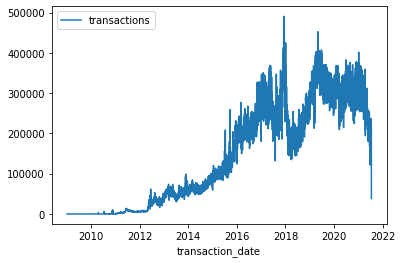

In [11]:
transactions_by_date.set_index('transaction_date').plot()

## Joining Data

### Example: How many files are covered by each type of software license?

In [7]:
dataset_ref = client.dataset("github_repos",project = "bigquery-public-data")
dataset = client.get_dataset(dataset_ref)

licenses_ref = dataset_ref.table("licenses")
licenses_table = client.get_table(licenses_ref)

client.list_rows(licenses_table, max_results = 5).to_dataframe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Cannot use bqstorage_client if max_results is set, reverting to fetching data with the tabledata.list endpoint.
  import sys


,repo_name,license
0,itcharlie/Net-Gnats,artistic-2.0
1,gitpan/Mojolicious-Plugin-Log-Timestamp,artistic-2.0
2,blatyo/bplot,artistic-2.0
3,philippfrenzel/taatttoooo,artistic-2.0
4,Freakstorm/Facebook-Mobile,artistic-2.0


In [9]:
files_ref = dataset.table("sample_files")
files_table = client.get_table(files_ref)

client.list_rows(files_table,max_results=5).to_dataframe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Cannot use bqstorage_client if max_results is set, reverting to fetching data with the tabledata.list endpoint.
  after removing the cwd from sys.path.


,repo_name,ref,path,mode,id,symlink_target
0,git/git,refs/heads/master,RelNotes,40960,62615ffa4e97803da96aefbc798ab50f949a8db7,Documentation/RelNotes/2.10.0.txt
1,np/ling,refs/heads/master,tests/success/plug_compose.t/plug_compose.ll,40960,0c1605e4b447158085656487dc477f7670c4bac1,../../../fixtures/all/plug_compose.ll
2,np/ling,refs/heads/master,fixtures/strict-par-success/parallel_assoc_lef...,40960,b59bff84ec03d12fabd3b51a27ed7e39a180097e,../all/parallel_assoc_left.ll
3,np/ling,refs/heads/master,fixtures/sequence/parallel_assoc_2tensor2_left.ll,40960,f29523e3fb65702d99478e429eac6f801f32152b,../all/parallel_assoc_2tensor2_left.ll
4,np/ling,refs/heads/master,fixtures/success/my_dual.ll,40960,38a3af095088f90dfc956cb990e893909c3ab286,../all/my_dual.ll


In [10]:
query = """SELECT L.license, COUNT(1) AS number_of_files
           FROM `bigquery-public-data.github_repos.sample_files` AS sf
           INNER JOIN `bigquery-public-data.github_repos.licenses` AS L
           ON sf.repo_name = L.repo_name
           GROUP BY L.license
           ORDER BY number_of_files DESC"""

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed = 10**10)
query_job = client.query(query,job_config=safe_config)

file_count_by_license = query_job.to_dataframe()

file_count_by_license

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,license,number_of_files
0,mit,20418006
1,gpl-2.0,16792944
2,apache-2.0,7106054
3,gpl-3.0,4902149
4,bsd-3-clause,2929226
5,agpl-3.0,1292022
6,lgpl-2.1,792881
7,bsd-2-clause,694532
8,lgpl-3.0,563605
9,mpl-2.0,472843
